# AllLife Credit Card Customer Segmentation

# Author: Jinad Patel
# Email: Jinadpatel@gmail.com
# GitHub URL: https://github.com/GreatLearningAIML1/gl-pgp-aiml-uta-intl-may20-jinadpatel/tree/master/Project5_AllLife_Credit_Card_Segmentation

## Background: 

* AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

## Objective: 

* To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

## Data Description:

* Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.

Key questions would be answered at the end of the notebook.

In [1]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import necessary libraries

import pandas as pd
import numpy as np
from IPython.core import display as disp

# Import sklearn required packages
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Import scipy 
from scipy.stats import zscore, skew
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, cdist

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_color_codes("dark")


In [3]:
# Adjust pandas display and formatting settings

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format        

# Increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Update default style and size of charts
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 15]

# Increase max number of rows and columns to display in pandas tables
pd.set_option('display.max_columns', 500)           
pd.set_option('display.max_rows', 500)
SEED=42

## Data Exploration and Univariate Analysis

In [4]:
df = pd.read_excel('Credit Card Customer Data.xlsx')

In [5]:
# Analyze the first 5 rows
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [6]:
# Check for null values, if any
print(df.isnull().sum())
print("Shape: {0}".format(df.shape))

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64
Shape: (660, 7)


In [7]:
# Check the data type of each column to avoid any issues later
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


### Observations:
* There are no null values as such
* All the columns are having data type as integer. 
* We have received a total number of 660 records and 7 data columns (Very less datapoints).

In [8]:
# Five point summary for above data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.00,330.50,190.67,1.00,165.75,330.50,495.25,660.00
Customer Key,660.00,"55,141.44","25,627.77","11,265.00","33,825.25","53,874.50","77,202.50","99,843.00"
Avg_Credit_Limit,660.00,"34,574.24","37,625.49","3,000.00","10,000.00","18,000.00","48,000.00","200,000.00"
Total_Credit_Cards,660.00,4.71,2.17,1.00,3.00,5.00,6.00,10.00
Total_visits_bank,660.00,2.40,1.63,0.00,1.00,2.00,4.00,5.00
Total_visits_online,660.00,2.61,2.94,0.00,1.00,2.00,4.00,15.00
Total_calls_made,660.00,3.58,2.87,0.00,1.00,3.00,5.00,10.00


### Observations:

* Sl_No is completely useless here as not necessary for clustering and might influence out analysis. It's better to drop it.
* Customer Key is completely useless here as not necessary for clustering and might influence out analysis. It's better to drop it.
* 'Avg_Credit_Limit': min is 3000 and max is 200000. Up to 2nd Quartile, we have the observations with 18000 limit. We can predict skewed data distribution (right tail). Mean is 34574.24.
* 'Total_Credit_Cards': Min is 1 and max is 10. Up to 2nd Quarile, we have the observations with 5 cards, which is closer to mean 4.71. The data distribution prediction looks normal.
* 'Total_visits_bank': min visits are 0 (May be online visits) and max visits are 5. Up to 2nd Quartile we have observations who have done 2 visits, which is closer to mean. Data distribution prediction is fairly normal.
* 'Total_visits_online': min is 0 and mac is 15. Up to 2nd Quartile,we got observations with 2 online visits which is closer to mean. Data distributions might slightly be skewed but so far fairly normal.
* 'Total_calls_made': min is 0 (Little misleading here) and max is 10. Up tp second Quartile, we got observations with 3 calls made. Which is closer to mean 3.58. Data distribution prediction looks fairly normal. 

In [9]:
# Drop unnecessary columns
df_mod = df.drop(columns=['Sl_No', 'Customer Key'])
df_mod.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [10]:
# Since we removed unwanted columns, It is safe to check for duplicates.
print("Number of duplicate entries: {0}".format(df_mod.duplicated().sum()))

Number of duplicate entries: 11


### Observations:
* There seem to be 11 duplicated entries and we need to treat those duplicated entries before further analysis.

### Univariate Analysis:
* Before we treat the data for the model training, let's look at the distributions and compare the results with our five point summary analysis.

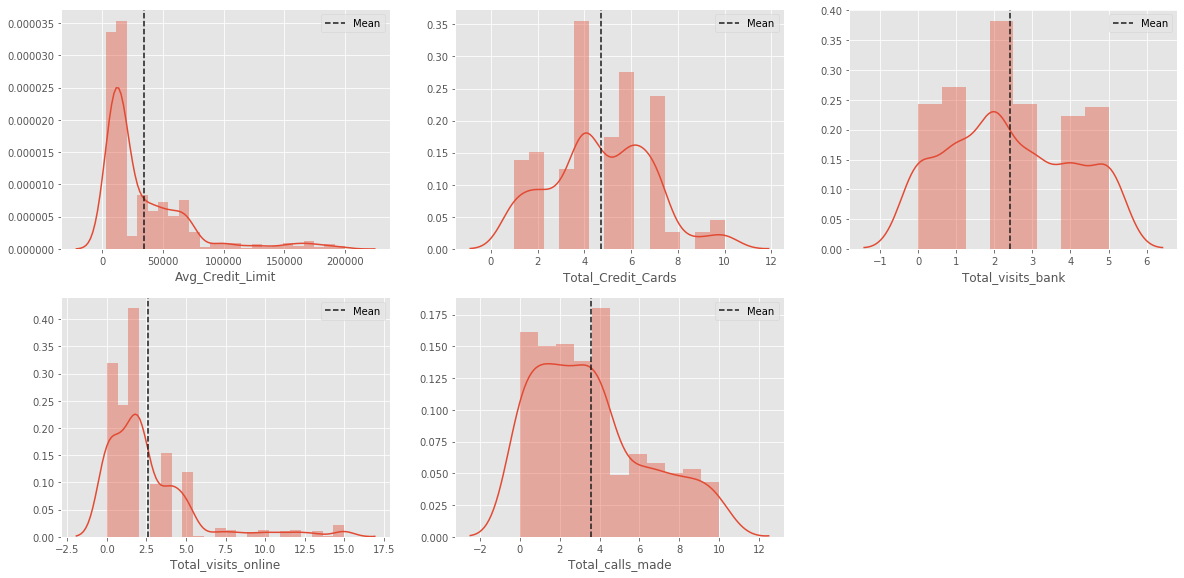

In [11]:
# Since all the columns are continuous, we don;t need to separate out the columns for univariate analysis.
for idx, col in enumerate(df_mod.columns):
    plt.subplot(3, 3, idx+1)
    sns.distplot(df_mod[col])
    plt.axvline(df_mod[col].mean(), linestyle="dashed", label="Mean", color="k")
    plt.legend(loc="best")

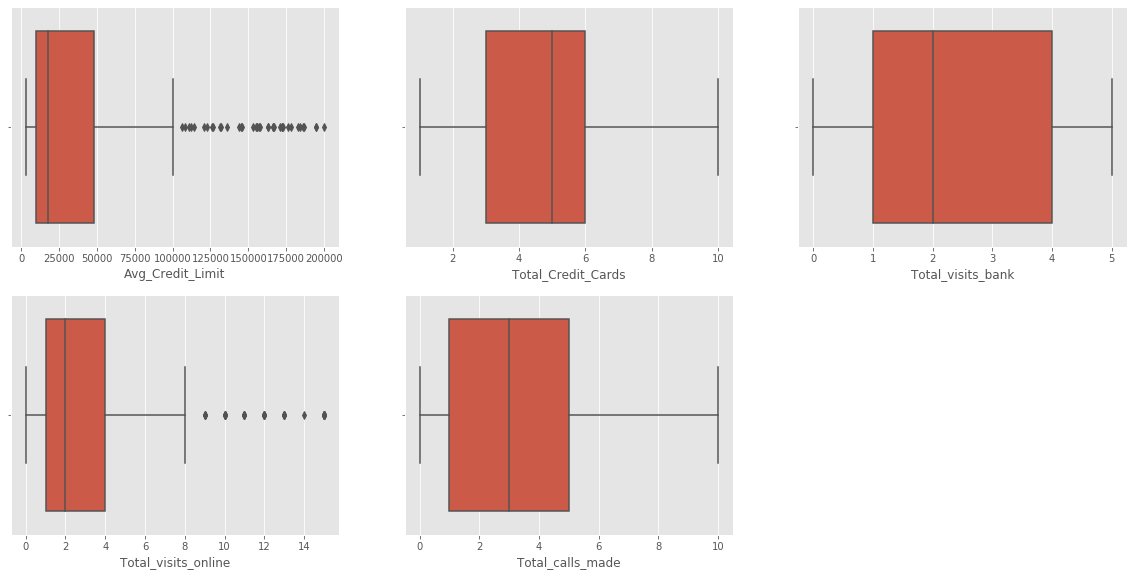

In [12]:
# Box plot analysis to figure out the outliers
for idx, col in enumerate(df_mod.columns):
    plt.subplot(3, 3, idx+1)
    sns.boxplot(x=df_mod[col]);
    idx += 1

In [13]:
# Skewness of the data
df_mod.skew().sort_values(ascending=False)

Total_visits_online   2.23
Avg_Credit_Limit      2.20
Total_calls_made      0.66
Total_Credit_Cards    0.14
Total_visits_bank     0.14
dtype: float64

### Observations:

* As compared to our five point summary analysis, 'Avg_Credit_Limit' and 'Total_visits_online' are highly skewed as compared to other data columns. 
* From the box plots, we see great amount of outliers for 'Avg_Credit_Limit' and 'Total_visits_online'.
* Skeweness might be the result of the outliers present in the data. 
* To conclude, we need to treat outliers present in the 'Avg_Credit_Limit' and 'Total_visits_online' and this will give us better data distribution for the same.
* Based on this early analysis, we can predict to have 3-4 clusters to support model training.

In [14]:
# Data treatment: Drop duplicate data and treat outliers for above found data columns
# Drop duplicates
df_mod_1 = df_mod.drop_duplicates(keep='last')
df_mod_1.shape

(649, 5)

In [15]:
# We got fewer observations. Original: 660 and Without duplicates: 649

# Apply log to treate outliers and than followed by zscore to normalize the data
df_scaled = df_mod_1.copy(deep=True)

# log scale
df_scaled['Avg_Credit_Limit'] = np.log(df_scaled['Avg_Credit_Limit'])

# Normalize the data
df_scaled = df_scaled.apply(zscore)

df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,649.00,0.00,1.00,-2.15,-0.75,-0.22,0.85,2.37
Total_Credit_Cards,649.00,-0.00,1.00,-1.71,-0.79,0.13,0.59,2.44
Total_visits_bank,649.00,0.00,1.00,-1.48,-0.86,-0.24,0.99,1.60
Total_visits_online,649.00,0.00,1.00,-0.89,-0.55,-0.21,0.47,4.19
Total_calls_made,649.00,0.00,1.00,-1.25,-0.90,-0.21,0.49,2.23


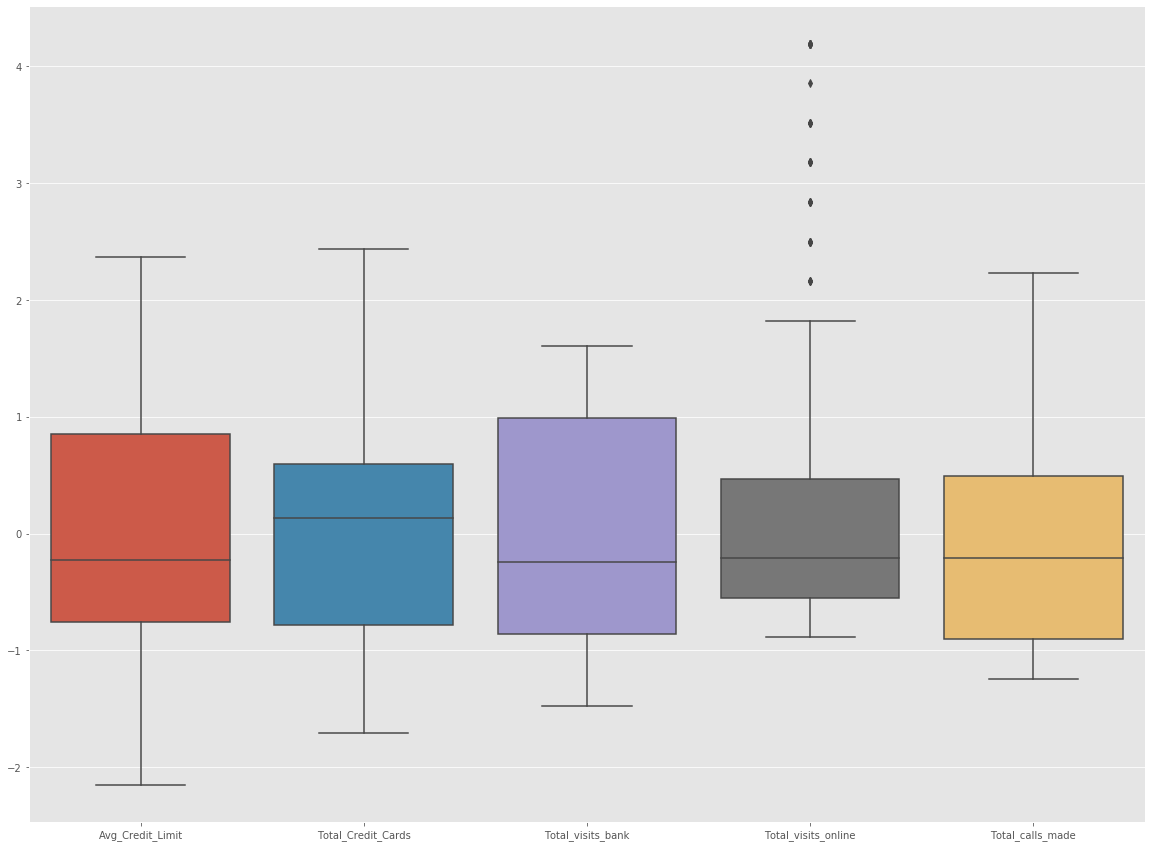

In [16]:
# Analyze the box plot to see if outliers are treated ot not
sns.boxplot(data=df_scaled)

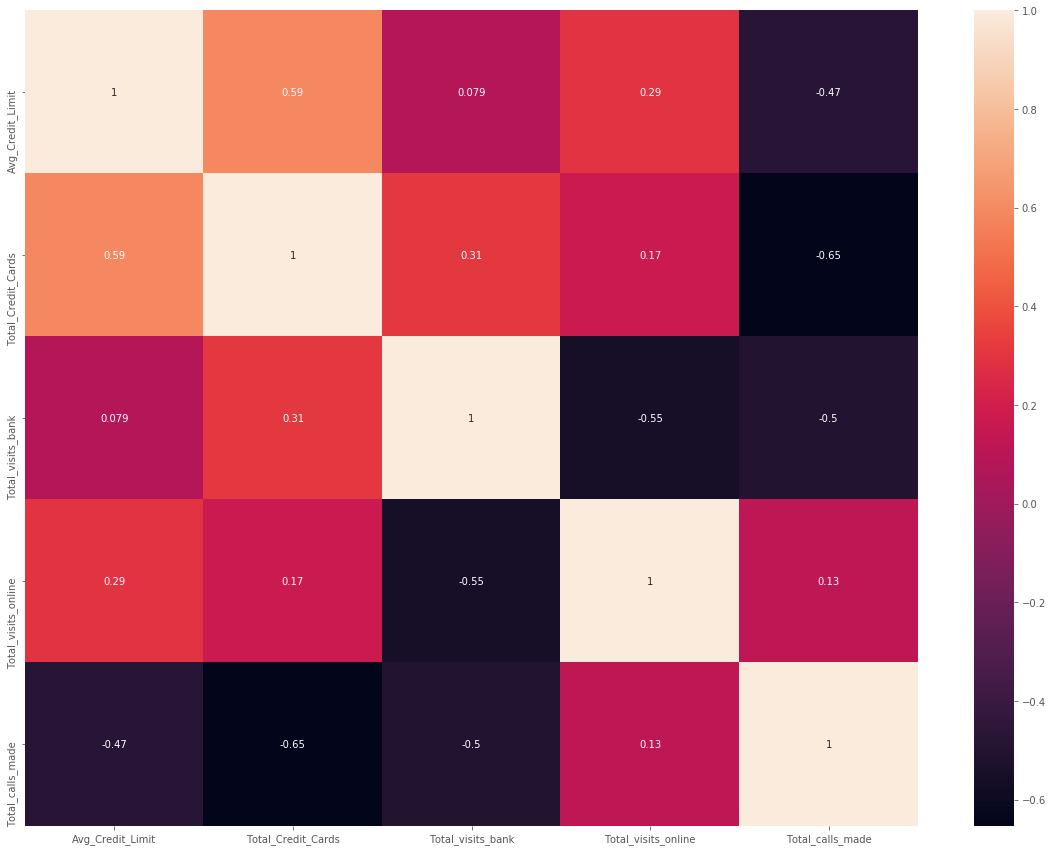

In [17]:
# Heat Map
sns.heatmap(df_scaled.corr(), annot=True)

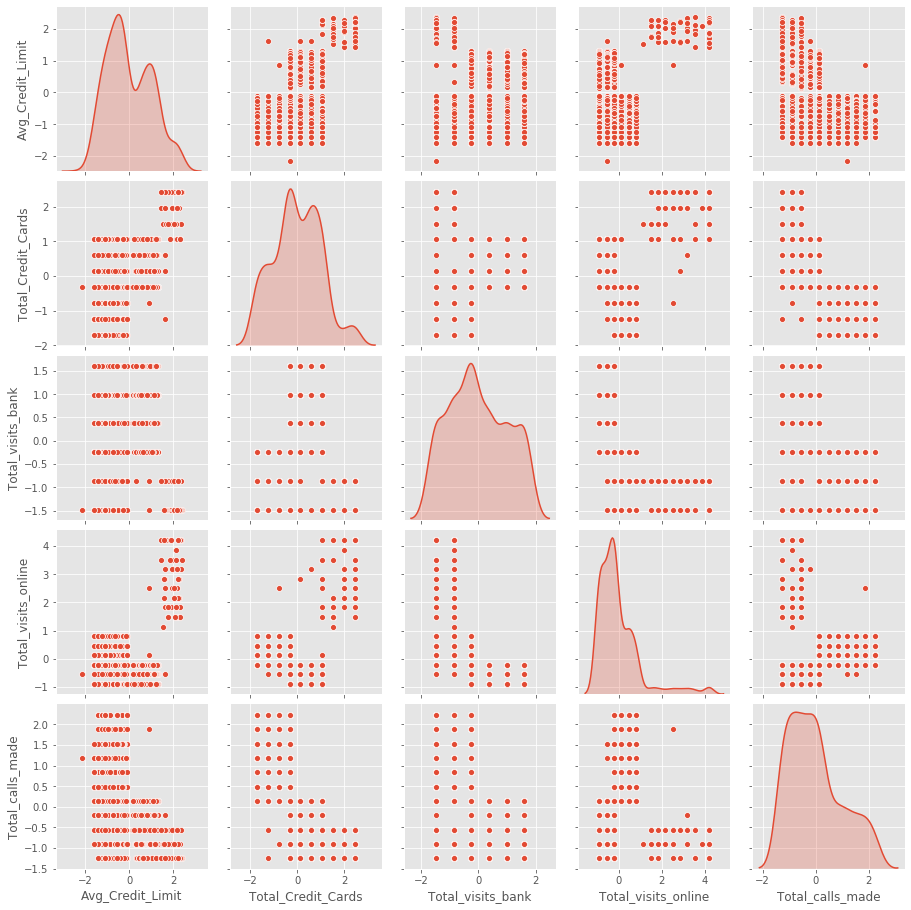

In [18]:
# Pairplot
sns.pairplot(df_scaled, diag_kind='kde')

### Observations:
* From the above analysis, we can conclude that 'Avg_Credit_Limit' and 'Total_Credit_Cards' are highly correlated. Meaning, people with more credit cards tend to have good average credit limit.
* Also, there is a negative correlation found between 'Total_Credit_Cards' and 'Total_calls_made'. But there is a good amount of correlation between 'Total_Credit_cards' and 'Total_cisits_bank'. Meaning, people with higher number of credit cards tend to visit bank more often.
* Based on the above analysis, we can tell no of clusters to 3,4 or 5 should be good enough for the desired outputs.

In [19]:
# Create a utility function that helps to create clusters and produce the silhoutte coefficient. It would be easy for the comparison later on.
# The method should be good enough to handle both, K Means na Heirarchical clusters.

# Map to store the silhouette score for later comparisons.
silhouette_score_map = {}

# Defaults to kmeans, 3 clusters and linkage method to be average. euclidean distance is used by default. box_plots_enabled will be the flag to enable box plots.

def clusters_outcome_generator(algorithm='kmeans', num_clusters=3, linkage_method='average', dendrogram_dist=3.25, 
                           dist_metric='euclidean', box_plots_enabled=True):
    ''' Custers outcome computational method
        algorithm - kmeans or hierarchical
        num_clusters - number of clsuters for kmeans clustering
        linkage_method - linkage method for hierarchical clustering
        dendrogram_dist - dendrogramic distance for certain number of clusters for hierarchical clustering
        dist_metric - distance metric for hierarchical clustering
    '''
    
    silhouette_score_key = algorithm
    silhoutte_coeff = None
    cluster_labels = None
    
    
    if algorithm == 'kmeans':
        # Get cluster labels using KMeans clustering
        kmeans_model = KMeans(random_state=SEED, n_clusters=num_clusters)
        cluster_labels = kmeans_model.fit_predict(df_scaled)
        silhouette_score_key += " " + str(num_clusters) + " Clusters"
        print("K-means Clustering Results - {0} clusters:".format(num_clusters))
        
    elif algorithm == 'hierarchical':
        # Get cluster labels using hierarchical clustering
        Z = linkage(df_scaled, metric=dist_metric, method=linkage_method, optimal_ordering=True)
        cluster_labels = fcluster(Z, t=dendrogram_dist, criterion='distance')
        clusters = max(cluster_labels)
        silhouette_score_key += " " + linkage_method.upper() + " with " + str(clusters) + " Clusters"
        print("Hierarchical Clustering Results: {0} linkage method/{1} clusters:".
              format(linkage_method, clusters))
        
    else:
        print("Please provide correct algorithm!")
        return
    
    # silhouette score
    silhoutte_coeff = round(silhouette_score(df_scaled, cluster_labels), 3)
    print('Silhouette Score: ', silhoutte_coeff)
    
    # Update silhouette score map
    silhouette_score_map[silhouette_score_key] = silhoutte_coeff
    
    df_mod_1['Cluster'] = cluster_labels
    df_counts = df_mod_1.groupby('Cluster').count().sort_index()
    df_q1     = df_mod_1.groupby('Cluster').quantile(0.25).round(2).sort_index()
    df_median = df_mod_1.groupby('Cluster').median().round(2).sort_index()
    df_q3     = df_mod_1.groupby('Cluster').quantile(0.75).round(2).sort_index()
    
    # Summary results
    summary_dict = {}
    for col in df_scaled.columns.to_list():
        summary_dict[col] = list(zip(df_q1[col].values, df_median[col].values, df_q3[col].values))    
    df_summary = pd.DataFrame(summary_dict, index=df_median.index)
    df_counts.index.name = 'Counts'    
    df_summary.index.name = 'Q1--Q2--Q3'
    
    # Display data frames
    disp.display(df_counts)
    disp.display(df_summary)
    
    if box_plots_enabled:
        # Draw box plots
        scaled_copy = df_scaled.copy(deep=True)
        scaled_copy['Cluster'] = cluster_labels
        scaled_copy.boxplot(by='Cluster', layout=(2,3));
    else:
        print("No box plots needed!")

## K-Means Clustering

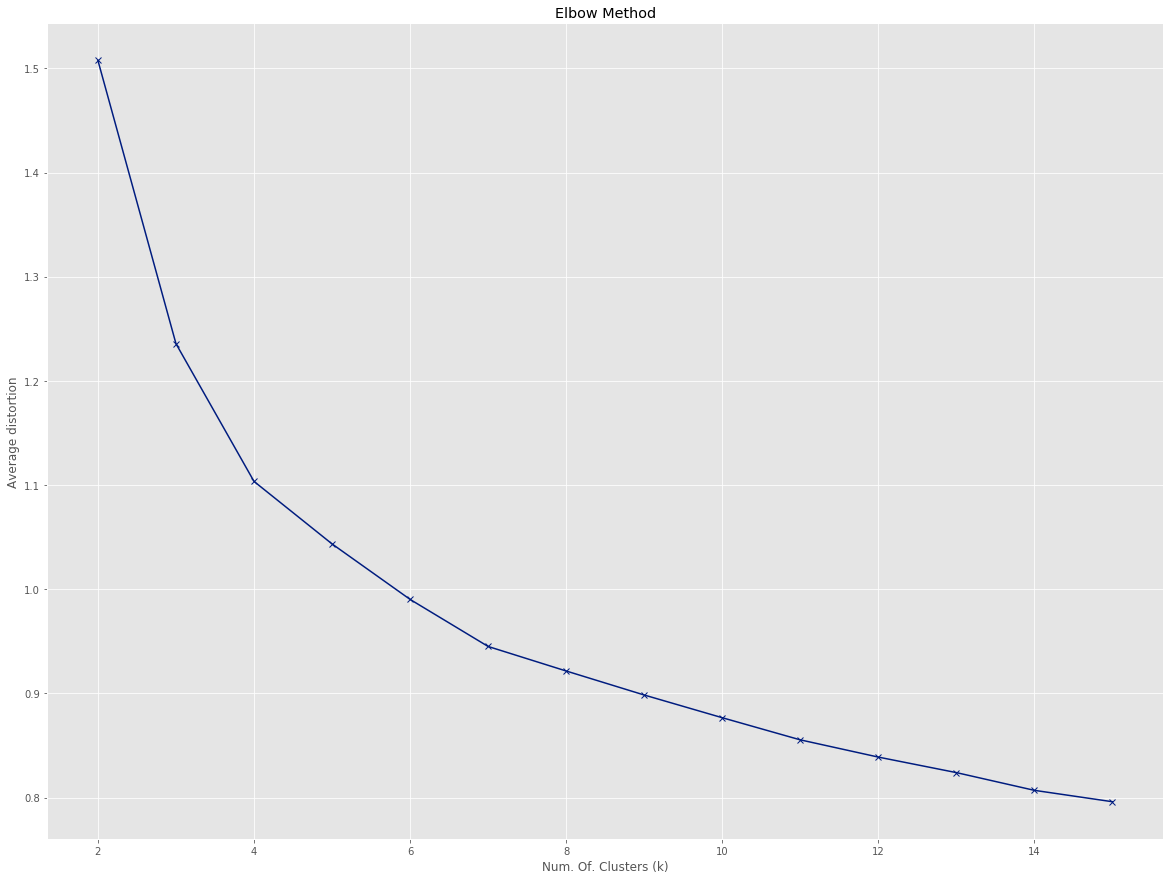

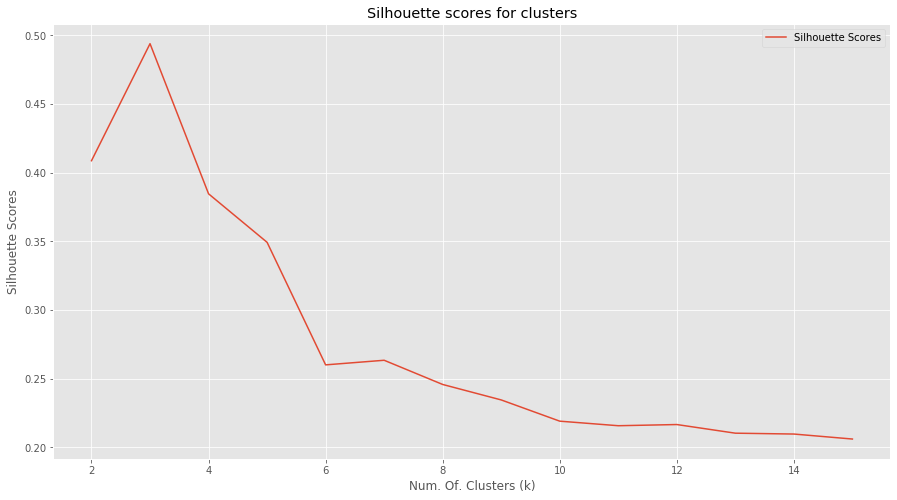

In [20]:
# Apply 2 to 15 clusters to find the optimal number of clusters required for K-Means
clusters_n=range(2,16)

# Mean distortions 
mean_distortions=[]

# Silhouette scores
silhouette_scores_reservoir=[]

# Get min distortions and silhouette scores for various number of clusters.
for k in clusters_n:
    model = KMeans(random_state=SEED, n_clusters=k)
    prediction = model.fit_predict(df_scaled)
    mean_dist = sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0]
    mean_distortions.append(mean_dist)
    silhouette_scores_reservoir.append(silhouette_score(df_scaled, prediction))

# Elbow plot 
plt.plot(clusters_n, mean_distortions, 'bx-');
plt.xlabel('Num. Of. Clusters (k)')
plt.ylabel('Average distortion')
plt.title('Elbow Method')
plt.show()

# Silhouette scores
pd.DataFrame({'Silhouette Scores': silhouette_scores_reservoir}, index = clusters_n).plot(figsize=(15,8));
plt.xlabel('Num. Of. Clusters (k)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette scores for clusters')
plt.show()

### Observations:
* From the above graph of "Elbow Method", we can find the possible candidates for number of clusters. From the graph, we can see the elbow (bend) at 4. 
* To decide based on numberical analysis, let's consider number of clusters to be 3,4 and 5.


K-means Clustering Results - 3 clusters:
Silhouette Score:  0.494


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Counts,,,,,
0,50,50,50,50,50
1,222,222,222,222,222
2,377,377,377,377,377


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Q1--Q2--Q3,,,,,
0,"(108750.0, 145500, 170000.0)","(8.0, 9, 10.0)","(0.0, 1, 1.0)","(8.0, 11, 13.0)","(0.0, 1, 2.0)"
1,"(8000.0, 12000, 16000.0)","(1.0, 2, 3.0)","(0.0, 1, 2.0)","(2.0, 4, 4.0)","(5.0, 7, 9.0)"
2,"(14000.0, 32000, 52000.0)","(4.0, 6, 6.0)","(3.0, 3, 5.0)","(0.0, 1, 2.0)","(1.0, 2, 3.0)"


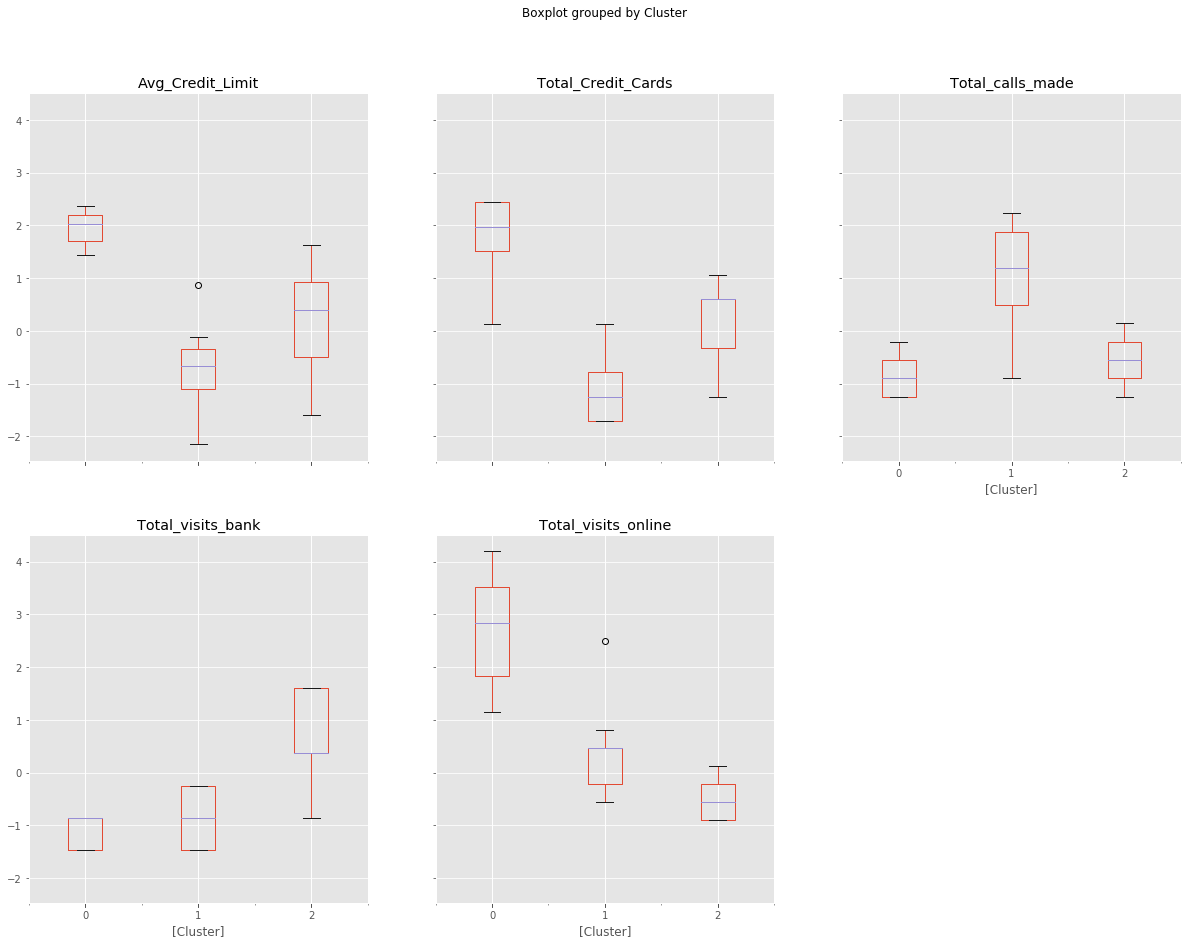

In [21]:
# 3 Clusters
clusters_outcome_generator(algorithm="kmeans", num_clusters=3)

### Observations (3 Clusters-KMeans):
* Here the data is distributed in 3 clusters. Cluster 0 has 50 data points, Cluster 1 has 222 data points and Cluster 2 has 377 data points.
* Cluster Analysis:
    * 0: It includes all the higher average credit limit customers form 108750 to 170000. Also, customers with higher number of credit cards ranging from 8 to 10 are included here. It has customers with less bank visits (0 to 1), higher online visits (8 to 13) and few calls made customers (0 to 2).
    * 1: Customers with lower Average credit limit (8000 to 16000), fewer credit cards (1 to 3), fewer bank visits (0 to 2), fewer online visits (2 to 4) and higher calling (5 to 9) included in this clusters.
    * 2: Customers with mid credit limit (14000 to 52000), mid number of credit cards (4 to 6), mid bank visits (3 to 5), less online visits (0 to 2) and low calling (1 to 3) included in this cluster. 

K-means Clustering Results - 4 clusters:
Silhouette Score:  0.385


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Counts,,,,,
0,217,217,217,217,217
1,220,220,220,220,220
2,162,162,162,162,162
3,50,50,50,50,50


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Q1--Q2--Q3,,,,,
0,"(37000.0, 49000, 64000.0)","(4.0, 6, 7.0)","(2.0, 3, 4.0)","(0.0, 1, 2.0)","(1.0, 2, 3.0)"
1,"(8000.0, 12000, 16000.0)","(1.0, 2, 3.0)","(0.0, 1, 2.0)","(2.75, 4, 4.25)","(5.0, 7, 9.0)"
2,"(8000.0, 12000, 17000.0)","(4.0, 6, 6.0)","(3.0, 4, 5.0)","(0.0, 1, 2.0)","(1.0, 2, 3.0)"
3,"(108750.0, 145500, 170000.0)","(8.0, 9, 10.0)","(0.0, 1, 1.0)","(8.0, 11, 13.0)","(0.0, 1, 2.0)"


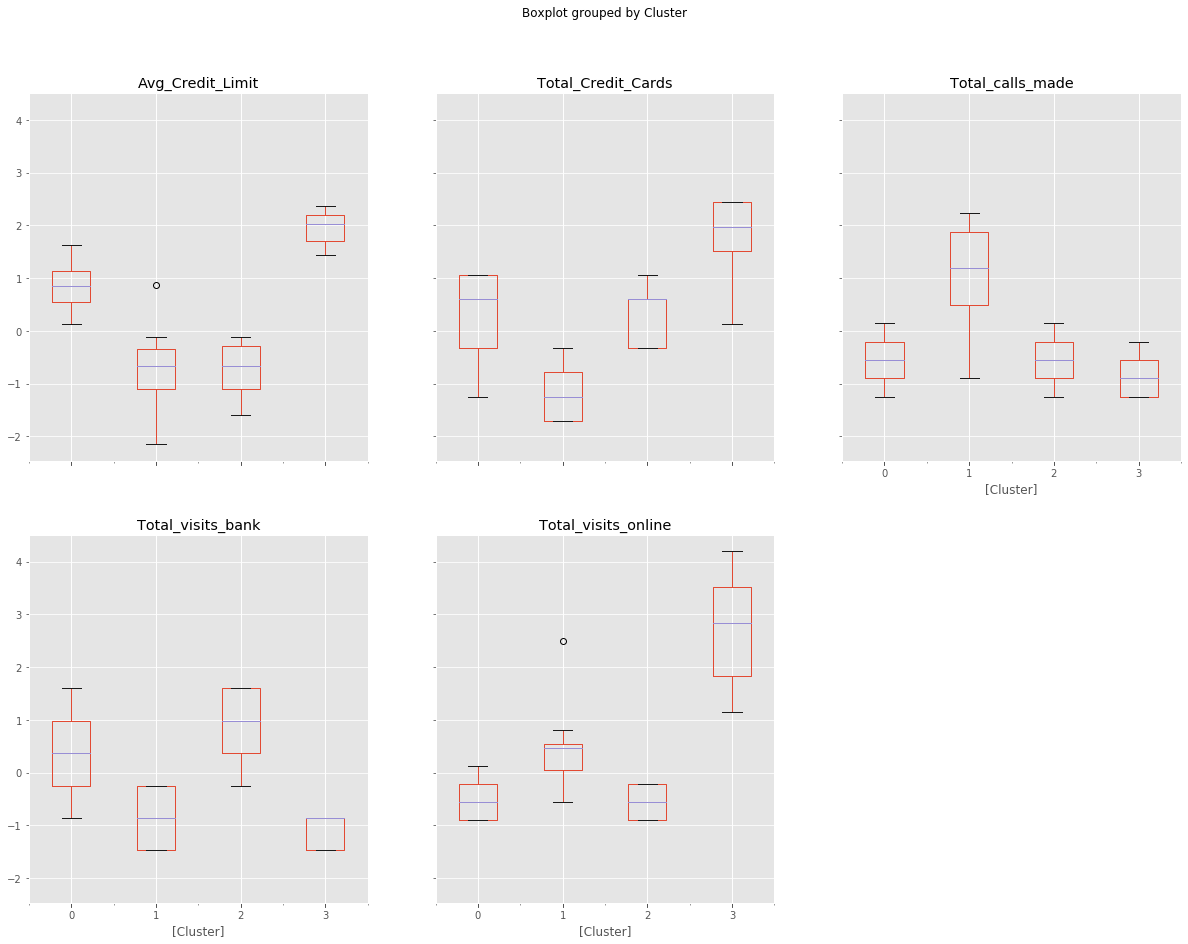

In [22]:
# 4 Clusters
clusters_outcome_generator(algorithm="kmeans", num_clusters=4)

### Observations(4 Clusters-KMeans):
* Here the data is distributed in 4 clusters. Cluster 0 has 217 data points, Cluster 1 has 220 data points and Cluster 2 has 162 data points and Cluster 3 has 50 data points.
* Cluster Analysis:
    * 0: It includes all the mid average credit limit customers form 37000 to 64000. Also, customers with mid number of credit cards ranging from 4 to 7 are included here. It has customers with mid bank visits (2 to 4), few online visits (0 to 2) and mid calls made customers (1 to 3).
    * 1: Customers with lower Average credit limit (8000 to 16000), fewer credit cards (0 to 2), mid bank visits (0 to 2), fewer online visits (2 to 5) and higher calling (5 to 9) included in this clusters.
    * 2: Customers with lower credit limit (8000 to 17000), high number of credit cards (4 to 6), mid bank visits (3 to 5), less online visits (0 to 2) and low calling (1 to 3) included in this cluster. 
    * 3: Customers with higher credit limit (108750 to 170000), high number of credit cards (8 to 10), few bank visits (0 to 1), higher online visits (8 to 13) and low calling (0 to 2) included in this cluster. 

K-means Clustering Results - 5 clusters:
Silhouette Score:  0.349


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Counts,,,,,
0,143,143,143,143,143
1,130,130,130,130,130
2,219,219,219,219,219
3,50,50,50,50,50
4,107,107,107,107,107


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Q1--Q2--Q3,,,,,
0,"(8000.0, 11000, 15000.0)","(4.0, 6, 6.0)","(3.0, 4, 5.0)","(0.0, 1, 2.0)","(1.0, 2, 3.0)"
1,"(34250.0, 49000, 62750.0)","(4.0, 6, 6.0)","(2.0, 2, 3.0)","(0.0, 1, 2.0)","(1.0, 2, 3.0)"
2,"(8000.0, 12000, 16000.0)","(1.0, 2, 3.0)","(0.0, 1, 2.0)","(3.0, 4, 4.5)","(5.0, 7, 9.0)"
3,"(108750.0, 145500, 170000.0)","(8.0, 9, 10.0)","(0.0, 1, 1.0)","(8.0, 11, 13.0)","(0.0, 1, 2.0)"
4,"(36000.0, 43000, 61500.0)","(5.0, 6, 7.0)","(4.0, 5, 5.0)","(0.0, 1, 2.0)","(1.0, 2, 3.0)"


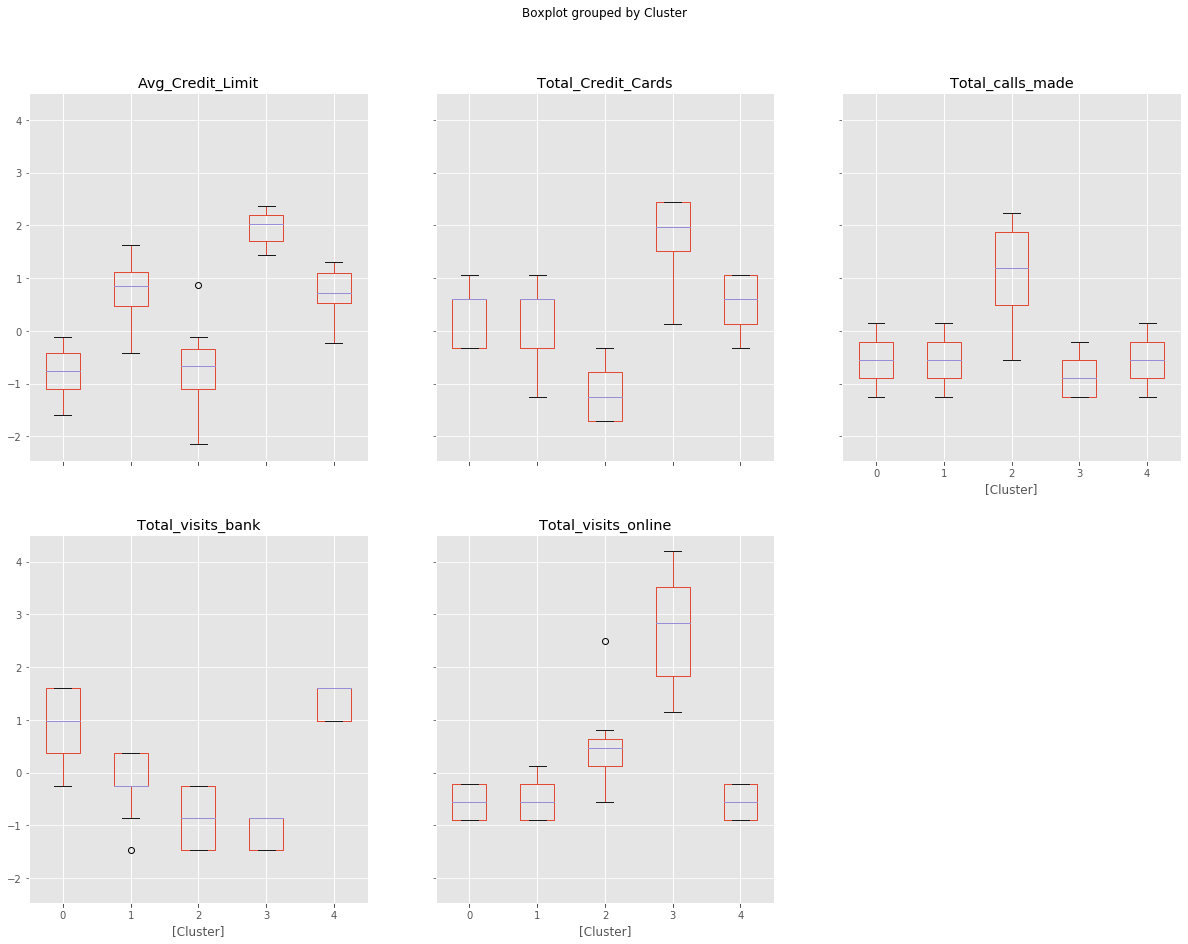

In [23]:
# 5 clusters
clusters_outcome_generator(algorithm="kmeans", num_clusters=5)

### Observations (5 Clusters-KMeans):
* Here the data is distributed in 5 clusters. Cluster 0 has 143 data points, Cluster 1 has 130 data points and Cluster 2 has 219 data points and Cluster 3 has 50 data points and Cluster 4 has 107 data points.
* Cluster Analysis:
    * 0: It includes all the lower average credit limit customers form 8000 to 15000. Also, customers with mid number of credit cards ranging from 4 to 6 are included here. It has customers with mid bank visits (3 to 4), few online visits (0 to 2) and mid calls made customers (1 to 3).
    * 1: Customers with mid Average credit limit (34250 to 62750), mid number of credit cards (4 to 6), mid bank visits (2 to 3), fewer online visits (0 to 2) and low calling (1 to 3) included in this clusters.
    * 2: Customers with lower credit limit (8000 to 17000), low number of credit cards (1 to 3), low bank visits (0 to 2), mid online visits (3 to 5) and higher calling (5 to 9) included in this cluster. 
    * 3: Customers with higher credit limit (108750 to 170000), high number of credit cards (8 to 10), few bank visits (0 to 1), higher online visits (8 to 13) and low calling (0 to 2) included in this cluster.
    * 4: Customers with mid Average credit limit (34250 to 62750), mid number of credit cards (5 to 7), higher bank visits (4 to 5), fewer online visits (0 to 2) and low calling (1 to 3) included in this clusters.

### Analysis:
* From the computational analysis of 3,4 and 5 clusters, we can see lot of overlapping with 5 clusters. This would tend to overfit. I would lean towards the clusters with 3 or 4 formation. 4 clusters looks much better so far.

# Hierarchical Clustering
* The action item would be to choose best linkage method and analyze the clusters using box plots.

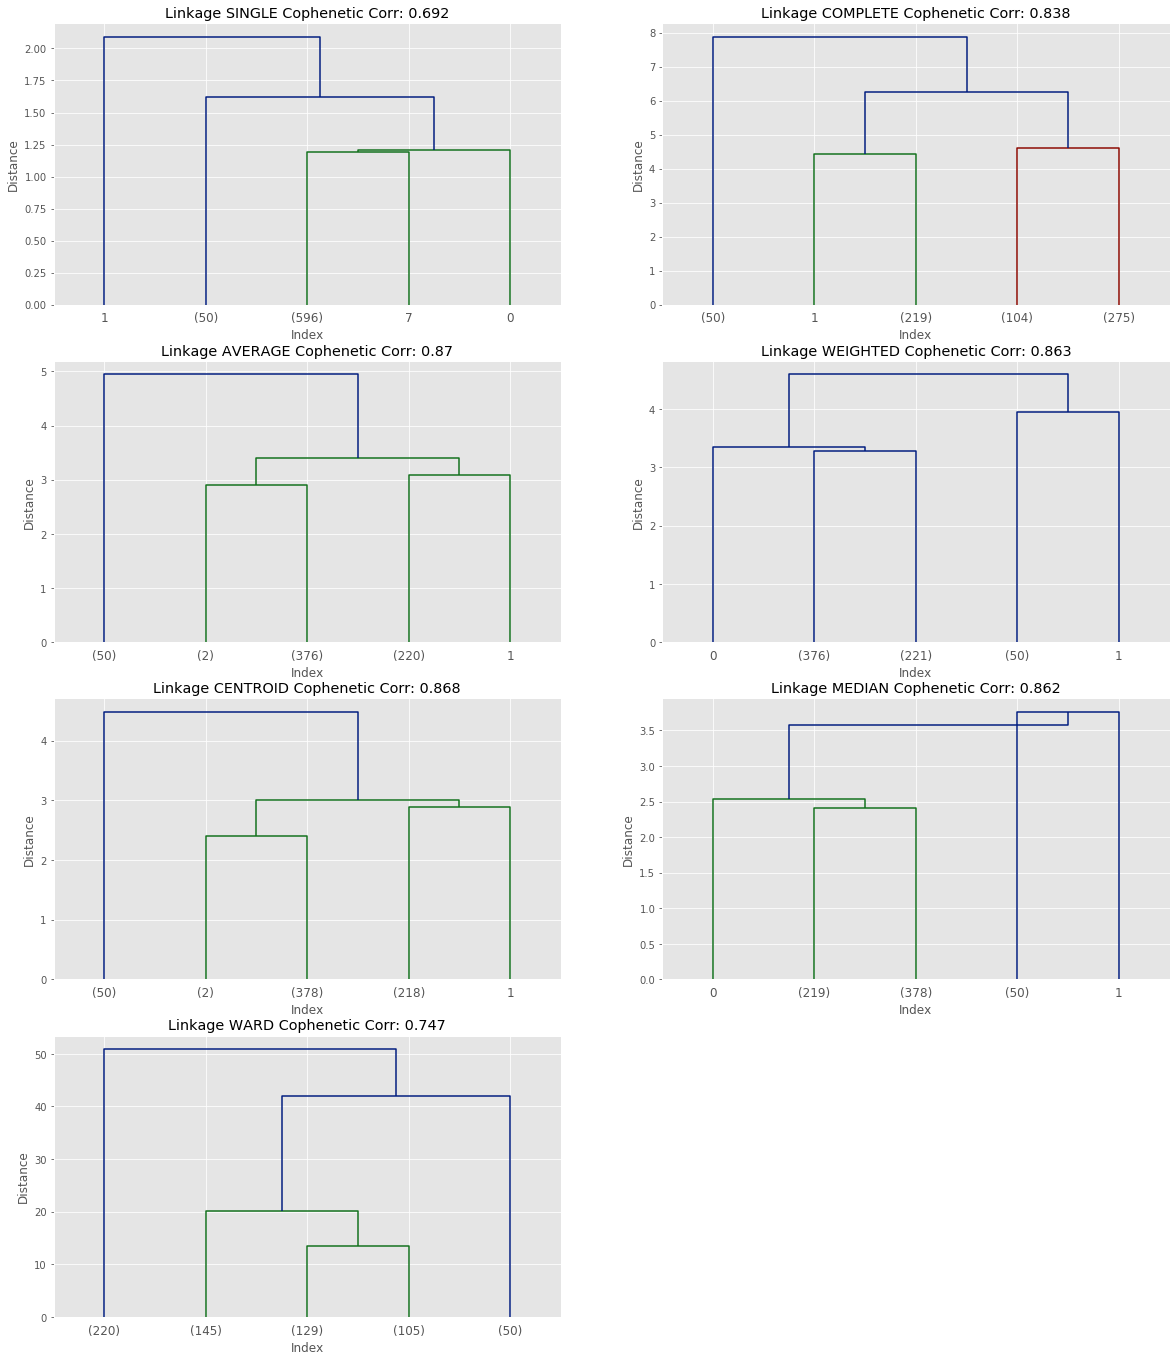

In [24]:
# Initialize list of all linkage methods
lnkg_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']    


# Initialize index to 1 for subplots
idx=1
# Plot dendrograms and calculate cophenetic correlations
plt.figure(figsize=(20,30))
for lnkg in lnkg_methods:
    Z = linkage(df_scaled, metric='euclidean', method=lnkg, optimal_ordering=True)
    # Compute the cophenetic correlation
    c, _ = cophenet(Z , pdist(df_scaled))
    # Dendrogram
    plt.subplot(5, 2, idx)
    plt.title('Linkage ' + lnkg.upper() + ' Cophenetic Corr: ' + str(round(c, 3)))    
    plt.xlabel('Index')
    plt.ylabel('Distance')
    dendrogram(Z, p=5, truncate_mode='lastp')
    idx += 1

### Observations (Dendograms):
* From the above dendoframs, we can conclude that Average linjage method has the highest cophenetic correlation. 
* Weighted and Median and Centroid are perfroming almost equal
* In terms of distribution, Ward has performed outstanding as compared to the other.

In [25]:
# Consider Average and Ward linkage method out of all and calculate silhoutte for different clusters
map = {
    'average': [4,3.25,3.05,2.75],
    'ward': [45,30,18,12]
}

dict_outcome = {}
for lnkg, dist in map.items():
    Z = linkage(df_scaled, metric='euclidean', method=lnkg, optimal_ordering=True)
    for d in dist:
        clusters = fcluster(Z, t=d, criterion='distance')
        score = silhouette_score(df_scaled, clusters)
        dict_outcome[lnkg.upper() + ' with ' + str(max(clusters)) + ' clusters'] = round(score,3)

pd.DataFrame(dict_outcome, index=['Silhouette Score'])

,AVERAGE with 2 clusters,AVERAGE with 3 clusters,AVERAGE with 4 clusters,AVERAGE with 5 clusters,WARD with 2 clusters,WARD with 3 clusters,WARD with 4 clusters,WARD with 5 clusters
Silhouette Score,0.50,0.49,0.46,0.39,0.41,0.49,0.37,0.34


### Observations:
* As we can see, Average and Ward with 3 clusters have same silhoutte score. 
* In both linkage methods, 5 clusters perform really poor as shown

Hierarchical Clustering Results: average linkage method/3 clusters:
Silhouette Score:  0.494


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Counts,,,,,
1,50,50,50,50,50
2,378,378,378,378,378
3,221,221,221,221,221


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Q1--Q2--Q3,,,,,
1,"(108750.0, 145500, 170000.0)","(8.0, 9, 10.0)","(0.0, 1, 1.0)","(8.0, 11, 13.0)","(0.0, 1, 2.0)"
2,"(14000.0, 32000, 52000.0)","(4.0, 6, 6.0)","(3.0, 3, 4.75)","(0.0, 1, 2.0)","(1.0, 2, 3.0)"
3,"(8000.0, 12000, 16000.0)","(1.0, 2, 3.0)","(0.0, 1, 2.0)","(2.0, 4, 4.0)","(5.0, 7, 9.0)"


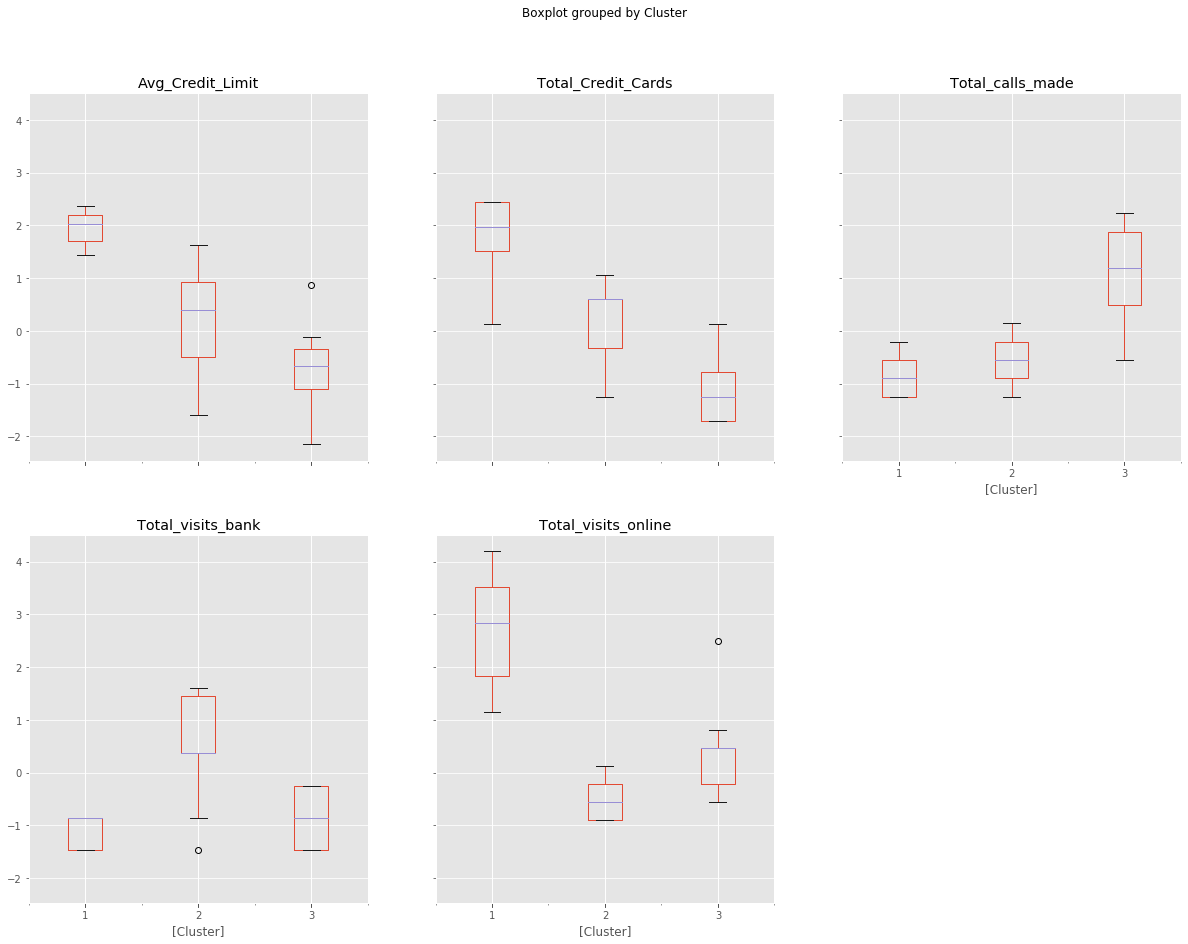

In [26]:
# Let's consider Average and Ward with 3 clusters
clusters_outcome_generator(algorithm='hierarchical', linkage_method='average', dendrogram_dist=3.25)

### Observation (3 Clusters-Hierarchical):
* Here the data is distributed in 3 clusters. Cluster 0 has 50 data points, Cluster 1 has 378 data points and Cluster 2 has 221 data points.
* Cluster Analysis:
    * 0: It includes all the higher average credit limit customers form 108750 to 170000. Also, customers with higher number of credit cards ranging from 8 to 10 are included here. It has customers with less bank visits (0 to 1), higher online visits (8 to 13) and few calls made customers (0 to 2).
    * 1: Customers with lower Average credit limit (14000 to 52000), mid credit cards (4 to 6), higher bank visits (3 to 5), fewer online visits (0 to 2) and lower calling (1 to 3) included in this clusters.
    * 2: Customers with lower credit limit (8000 to 16000), lower number of credit cards (1 to 3), lower bank visits (0 to 2), less online visits (2 to 4) and higher calling (5 to 9) included in this cluster. 

Hierarchical Clustering Results: ward linkage method/3 clusters:
Silhouette Score:  0.494


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Counts,,,,,
1,220,220,220,220,220
2,379,379,379,379,379
3,50,50,50,50,50


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Q1--Q2--Q3,,,,,
1,"(8000.0, 12000, 16000.0)","(1.0, 2, 3.0)","(0.0, 1, 2.0)","(2.75, 4, 4.25)","(5.0, 7, 9.0)"
2,"(13500.0, 32000, 52000.0)","(4.0, 6, 6.0)","(2.5, 3, 4.5)","(0.0, 1, 2.0)","(1.0, 2, 3.0)"
3,"(108750.0, 145500, 170000.0)","(8.0, 9, 10.0)","(0.0, 1, 1.0)","(8.0, 11, 13.0)","(0.0, 1, 2.0)"


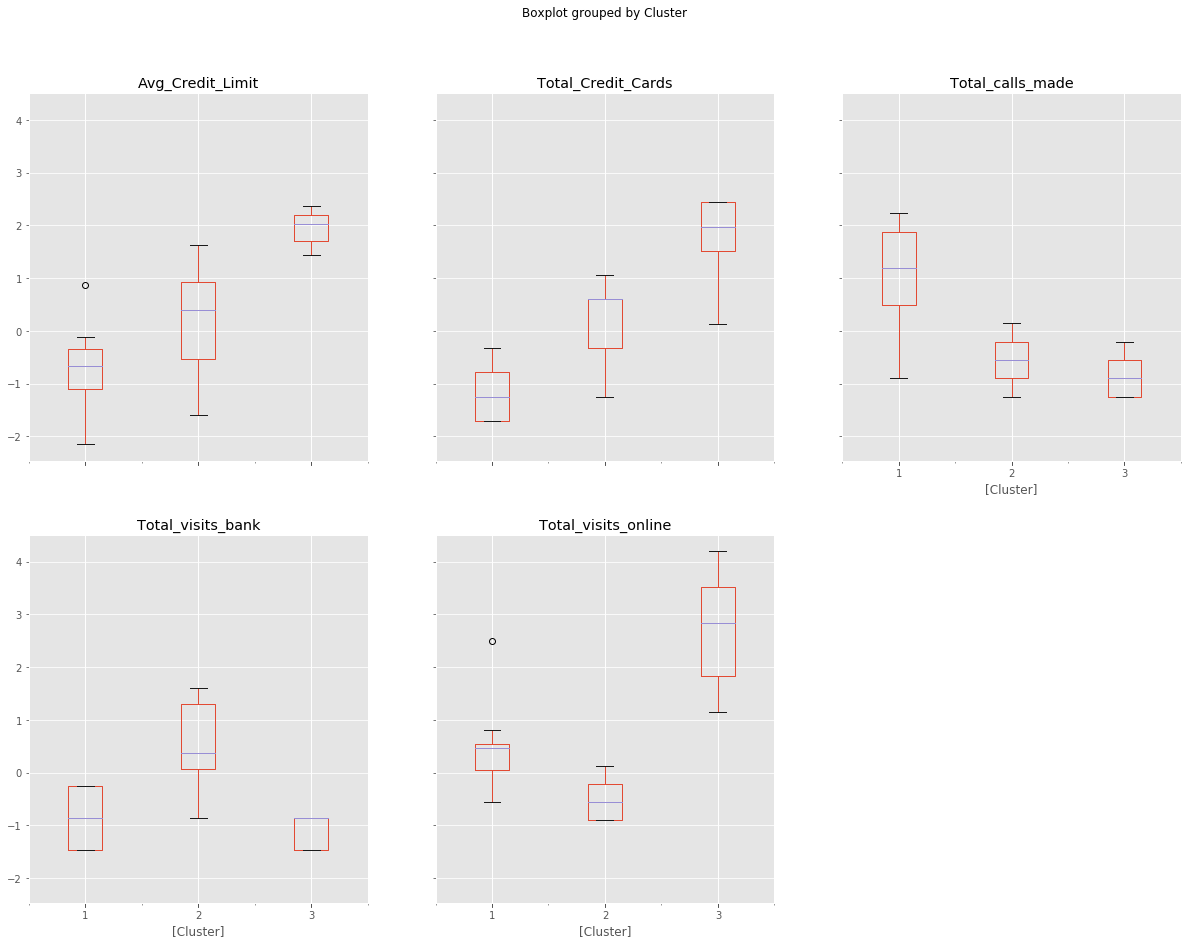

In [27]:
# Test ward with 3 clusters
clusters_outcome_generator(algorithm='hierarchical', linkage_method='ward', dendrogram_dist=30)

### Observations(3 Clusters: Hierarchical):
* Same results as Average and KMeans with 3 clusters

In [28]:
# Check the Silhouette scores for the above methods
pd.DataFrame(silhouette_score_map, index=['Average Silhouette Score'])


,kmeans 3 Clusters,kmeans 4 Clusters,kmeans 5 Clusters,hierarchical AVERAGE with 3 Clusters,hierarchical WARD with 3 Clusters
Average Silhouette Score,0.49,0.39,0.35,0.49,0.49


### Comparison of KMeans & Heirarchical with 3 Clusters


* Cluster Analysis: Cluster 0 has 50, Cluster 1 has 222-378, Cluster 2 has 377-221 customers.
    * 0: Customers with higher average credit limit (108750 -170000), higher credit cards (8 to 9), lower bank visites (0 to 1), higher online visits (8-13) and fewer calling (0 to 2) are included in this segment.
    * 1: Customers with mid acerage credit limit (14000 to 52000), mid number of credit cards (4 to 6). mid number of bank visitors (3 to 5), fewer online visits (0 to 2) and mid number of callers (1 to 3) are included in this segment.
    * 2: Customers with mid Average credit limit (8000 to 16000), lower number of credit cards (1 to 2), less bank visits (0 to 2), mid number of online visits (2 to 4) and higher number of callers (5 to 9) are included in this segment.
    
Note: Both methods with 3 clusters yields the same results. The Silhouette score is also very much similar her 0.49 for Kmeans and Hierarchical clusters with Average linkage method and 3 clusters.

## Answers to the Key Questions:

### 1. How many different segments of customers are there?
* As we derived above, the customers can be classified into three different segments based on the features. Mostly, Average credit limit plays crucial role here as shown above.

### 2. How are these segments different from each other?
* As Mentioned above, all three segments are based off customers individual attributes, like average credit limit, total credit cards, visits etc. I would summarize the segments again.
* Cluster 0: It includes customers with higher average credit limits. Also, the customers in this segments tend to have higher number of credit cards. The customer in this segments have higher number of online visits as compared to bank and calling.
* Cluster 1: It includes customers in this segment with mid range of average credit limits. Also, this results in mid number of credit card holders. Customers in this segment like to visit bank in person instead of online and calling.
* Cluster 2: It includes customers in this segment with less average credit card limits. This results in the less number of credit cards. They have moderate online visitors and very few inperson or caller customers.

### 3. What are your recommendations to the bank on how to better market to and service these customers?
* Out of all 3 segments, I am leaning towards the third segment for the personalized campaigns and targetting customers. Let's discuss each segments one by one. 

* Segment 1: Customers who fall into these segments tend to have higher number of credit cards. They also have higher average credit ccard limits. If we look at their preferred way of conducting communication with bank, it would be online. So these customers can be targeted for online banking or any new features that can be provided remotely. They tend to do very less bank visits. So going paper less is one of the good features they can be added to. 

* Segment 2: Customers in this segment tend to have mid number of credit limit and have mid number of credit cards. They tend to visit bank in person. So customers in this segment are good candidates for the lockers available in the bank. They can be offered lucrative deals for lockers and ATM machine deals. They can also be targeted for online features as they might want to get these services to avoid every day commutes.

* Segment 3: Customers in this segment have less credit limit and few number of credit cards. Also, they are frequent onlinee visitors. They can be good candidates for the credit card deals and online cash back deals. Bank can take advantage of customers in this segments to apply for the credit cards as these customers would be doing online shopping much more as compared to segments 2. Customers in this segments can easily move to segment one if proper campaign is performed here.